<a href="https://colab.research.google.com/github/MelKanyi/Hacker-News-Project/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HACKER NEWS API

#Introduction

Hacker News is a social news website focusing on computer science and entrepreneurship. It is run by Paul Graham's investment fund and startup incubator, Y Combinator. 

In general, content that can be submitted is defined as "anything that gratifies one's intellectual curiosity"

#Problem statement
According to a 2013 TechCrunch article: "Graham says that Hacker News gets a lot of complaints that it has a bias toward featuring stories about Y Combinator startups, but he says there is no such bias. 

With our model,we aim to predit titles that are trending to confirm or supress the claimed biasness

#Metric of success

#Experimental Design

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#read data from csv file
hack = pd.read_csv('hacker_news.csv')
hack.head(5)

,id,title,url,num_points,num_comments,author,created_at
0,12224879,Interactive Dynamic Video,http://www.interactivedynamicvideo.com/,386,52,ne0phyte,8/4/2016 11:52
1,10975351,How to Use Open Source and Shut the Fuck Up at...,http://hueniverse.com/2016/01/26/how-to-use-op...,39,10,josep2,1/26/2016 19:30
2,11964716,Florida DJs May Face Felony for April Fools' W...,http://www.thewire.com/entertainment/2013/04/f...,2,1,vezycash,6/23/2016 22:20
3,11919867,Technology ventures: From Idea to Enterprise,https://www.amazon.com/Technology-Ventures-Ent...,3,1,hswarna,6/17/2016 0:01
4,10301696,Note by Note: The Making of Steinway L1037 (2007),http://www.nytimes.com/2007/11/07/movies/07ste...,8,2,walterbell,9/30/2015 4:12


#Data Understanding

In [0]:
#check for number of rows in the data
len(hack)

20100

In [0]:
#description of the data tells us that comments is skewed but points are well distributed
hack.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20100.0,1.131753e+07,696439.944151,10176908.0,10701763.5,11284446.5,11926073.0,12578975.0
num_points,20100.0,5.029607e+01,107.107687,1.0,3.0,9.0,54.0,2553.0
num_comments,20100.0,2.480229e+01,56.107340,1.0,1.0,3.0,21.0,1733.0


In [0]:
#checkfor votes with votes > 10 and votes < 10
print(len(hack[hack['num_points'] < 10]), 'Posts with less than 10 votes')
print(len(hack[hack['num_points'] > 10]), 'Posts with more than 10 votes')

10271 Posts with less than 10 votes
9546 Posts with more than 10 votes


In [0]:
#check for votes with comments > 10 and comments < 10
#the stories with les than 10 comments are more compared to those with more than 10
print(len(hack[hack['num_comments'] < 10]), 'Posts with less than 10 comments')
print(len(hack[hack['num_comments'] > 10]), 'Posts with more than 10 comments')

13290 Posts with less than 10 comments
6562 Posts with more than 10 comments


In [0]:
#title with highest number of points
hack[hack['num_points'] == hack['num_points'].max()]['title'].iloc[0]

'Pardon Snowden'

In [0]:
# Understand the data types of the columns
hack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            20100 non-null  int64 
 1   title         20100 non-null  object
 2   url           17660 non-null  object
 3   num_points    20100 non-null  int64 
 4   num_comments  20100 non-null  int64 
 5   author        20100 non-null  object
 6   created_at    20100 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


In [0]:
#convert id to string
hack['id'] = hack['id'].apply(str)


In [0]:

# Looking at first five titles.
hack['title'].head(5)

0                            Interactive Dynamic Video
1    How to Use Open Source and Shut the Fuck Up at...
2    Florida DJs May Face Felony for April Fools' W...
3         Technology ventures: From Idea to Enterprise
4    Note by Note: The Making of Steinway L1037 (2007)
Name: title, dtype: object

In [0]:

#split data to month and year
hack['year'] = pd.DatetimeIndex(hack['created_at']).year
hack['month'] = pd.DatetimeIndex(hack['created_at']).month

In [0]:
#drop column not in use
hack.drop(['created_at'],axis=1,inplace=True)

In [0]:
hack.head(1)

,id,title,url,num_points,num_comments,author,year,month
0,12224879,Interactive Dynamic Video,http://www.interactivedynamicvideo.com/,386,52,ne0phyte,2016,8


##Natural Language Preprocessing

In [0]:
# Import libraries
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import re
import string

In [0]:
#Coverting review column data to string
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
             " ",          str(hack['title']))  # Replace all non-letters with spaces

#Lowercase and Remove punctuation

In [0]:
#Converting to lowercase and removing punctuations
hack['title'] = hack['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
hack['title'] = hack['title'].str.replace(',[^\w\s]','')

In [0]:
#cofirming the change to lower case
hack['title'].head()

0                            interactive dynamic video
1    how to use open source and shut the fuck up at...
2    florida djs may face felony for april fools' w...
3         technology ventures: from idea to enterprise
4    note by note: the making of steinway l1037 (2007)
Name: title, dtype: object

#Remove Stopwords

In [0]:
import nltk
nltk.download("popular")
from nltk.corpus import stopwords
set(stopwords.words('english'))
    
stop = stopwords.words('english')
hack['title'] = hack['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
hack['title'].head(5)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

0                            interactive dynamic video
1                       use open source shut fuck time
2    florida djs may face felony april fools' water...
3                 technology ventures: idea enterprise
4              note note: making steinway l1037 (2007)
Name: title, dtype: object

In [0]:
hack.head()

,id,title,url,num_points,num_comments,author,year,month
0,12224879,interactive dynamic video,http://www.interactivedynamicvideo.com/,386,52,ne0phyte,2016,8
1,10975351,use open source shut fuck time,http://hueniverse.com/2016/01/26/how-to-use-op...,39,10,josep2,2016,1
2,11964716,florida djs may face felony april fools' water...,http://www.thewire.com/entertainment/2013/04/f...,2,1,vezycash,2016,6
3,11919867,technology ventures: idea enterprise,https://www.amazon.com/Technology-Ventures-Ent...,3,1,hswarna,2016,6
4,10301696,note note: making steinway l1037 (2007),http://www.nytimes.com/2007/11/07/movies/07ste...,8,2,walterbell,2015,9


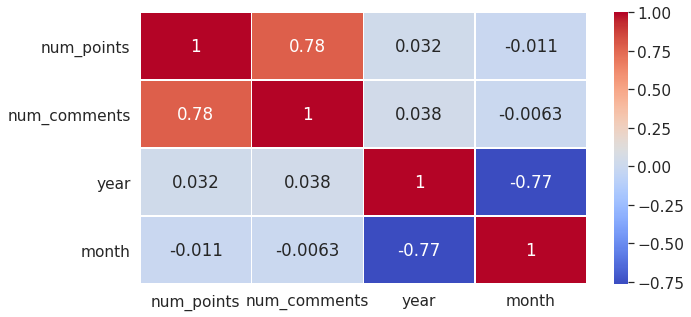

In [0]:
#correlation of numeric variables
sns.set(font_scale=1.4)
plt.figure(figsize = (10,5))
sns.heatmap(hack.corr(),cmap='coolwarm',annot=True,linewidths=.5)

correlation by id and year , num_comments and num_points

#EXPLORATORY DATA ANALYSIS

#Univariate

In [0]:
#visualize title
hack.title.value_counts()

solving wrong problems                                                  3
brave, new post open source world                                       3
400gbps: winter whopping weekend ddos attacks                           3
hacker nsa willing talk. willing listen                                 3
ad blocking                                                             3
                                                                       ..
incredible superspeed space engine could power humans mars six weeks    1
leap second: clocks accurate earth                                      1
60m people slated get $15 minimum wage                                  1
security auditor idiot. give information wants?                         1
create slack notifications using amazon dash button                     1
Name: title, Length: 19933, dtype: int64

In [0]:
hack.isnull().any()
#no null values in our dataset

id              False
title           False
url              True
num_points      False
num_comments    False
author          False
year            False
month           False
dtype: bool

In [0]:
hack.duplicated().any()
#no duplicates in our dataset

False

In [0]:
hack2 =hack.drop(hack.index[hack['author']=='[deleted]'])

Text(0, 0.5, 'Number of titles')

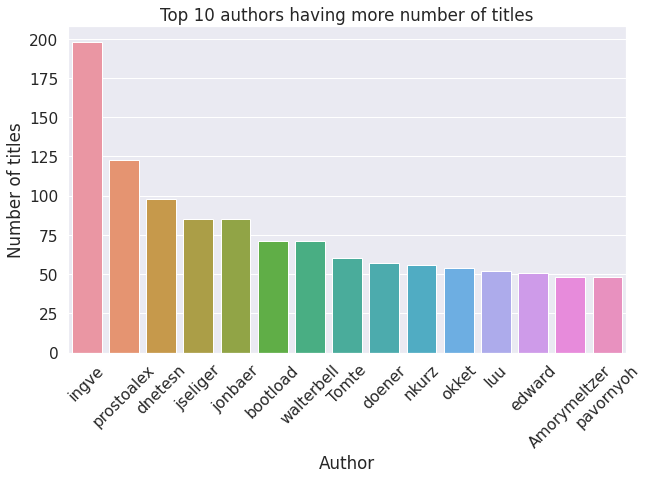

In [0]:
plt.figure(figsize = (10,6))
chart = sns.countplot(x = 'author', data = hack2, 
                      order = hack2.author.value_counts().iloc[:15].index)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)
plt.title('Top 10 authors having more number of titles')
plt.xlabel('Author')
plt.ylabel('Number of titles')

ingve publishes a lot of stories compared to the rest.

He/She is folllowed by prostoalex and chetesn

In [0]:
#we will look at Top 10 titles with most points.
hack3 = pd.DataFrame(hack2.groupby('title').agg({'num_points':['sum']}))
hack3.columns = ['sum']

hack3= hack3.reset_index()

In [0]:
hack3_sorted_desc = hack3.sort_values('sum',ascending = False)
hack3_sorted_desc.head(10)

,title,sum
12872,pardon snowden,2553
17634,tell hn: new features moderator,2381
11076,"master plan, part deux",1851
14325,responsive pixel art,1622
9084,i've liberated modules,1573
17259,"sued, east texas, using google play store [video]",1565
9377,instagram's million dollar bug,1562
17672,tensorflow: open-source library machine intell...,1559
881,amazon's customer service backdoor,1447
10305,lee sedol beats alphago game 4,1395


Text(0, 0.5, 'Points')

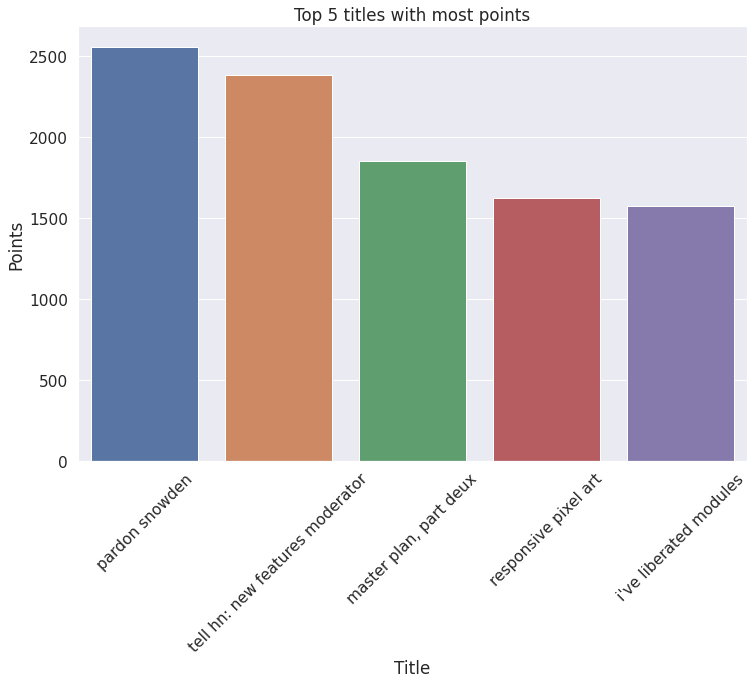

In [0]:
plt.figure(figsize = (12,8))

chart1 = sns.barplot(x = 'title', y = 'sum', data = hack3_sorted_desc[:5])
chart1.set_xticklabels(chart1.get_xticklabels(), rotation = 45)
plt.title('Top 5 titles with most points')
plt.xlabel('Title')
plt.ylabel('Points')

In [0]:
hack3.head()

,title,sum
0,"""fs"" unpublished restored",23
1,"""this tayo. he's 11 showed game built called s...",51
2,"""wizzards"" adware",68
3,#1 dietary risk factor eating enough fruit,1
4,#1 mistake driving growth,5


In [0]:
#we will look at Top 10 titles with most points.
hack4 = pd.DataFrame(hack.groupby('title').agg({'num_comments':['sum']}))
hack4.columns = ['sum']

hack4= hack4.reset_index()

In [0]:
hack4_sorted_desc = hack4.sort_values('sum',ascending = False)
hack4_sorted_desc.head(10)

,title,sum
9658,iphone 7,1733
2266,ask hn: hiring? (august 2016),947
2267,ask hn: hiring? (september 2016),910
3125,ask hn: what's best tool used use exist anymore?,868
3546,basic income next big thing,809
12872,pardon snowden,781
11062,massachusetts bans employers asking applicants...,760
19010,vlc contributor living aleppo writing paris at...,705
2516,ask hn: much make amazon? much make amazon,691
11076,"master plan, part deux",677


Text(0, 0.5, 'comments')

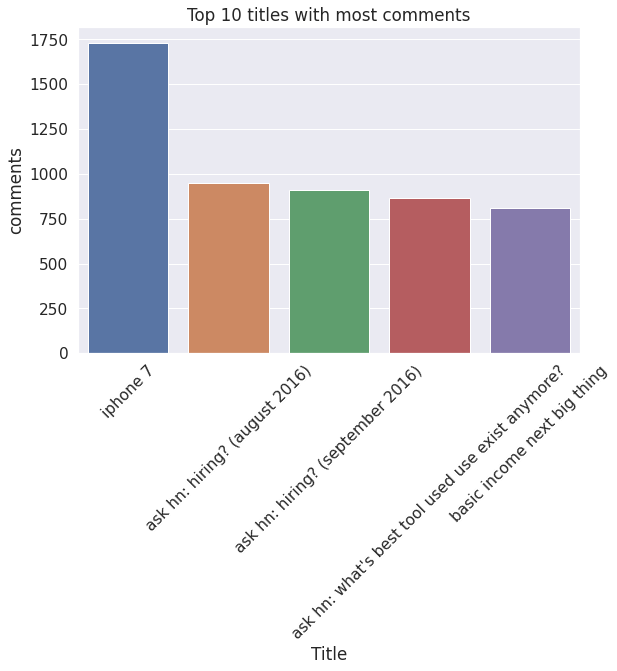

In [0]:
plt.figure(figsize = (9,6))

chart1 = sns.barplot(x = 'title', y = 'sum', data = hack4_sorted_desc[:5])
chart1.set_xticklabels(chart1.get_xticklabels(), rotation = 45)
plt.title('Top 10 titles with most comments')
plt.xlabel('Title')
plt.ylabel('comments')

#Bivariate
#Wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS

In [0]:
words = hack["title"].values

In [0]:
type(words[10000])

str

In [0]:
ls = []

for i in words:
    ls.append(str(i))
    

In [0]:
ls[:5]

['interactive dynamic video',
 'use open source shut fuck time',
 "florida djs may face felony april fools' water joke",
 'technology ventures: idea enterprise',
 'note note: making steinway l1037 (2007)']

In [0]:
type(ls[10000])

str

In [0]:
words[0]

'interactive dynamic video'

(-0.5, 1599.5, 799.5, -0.5)

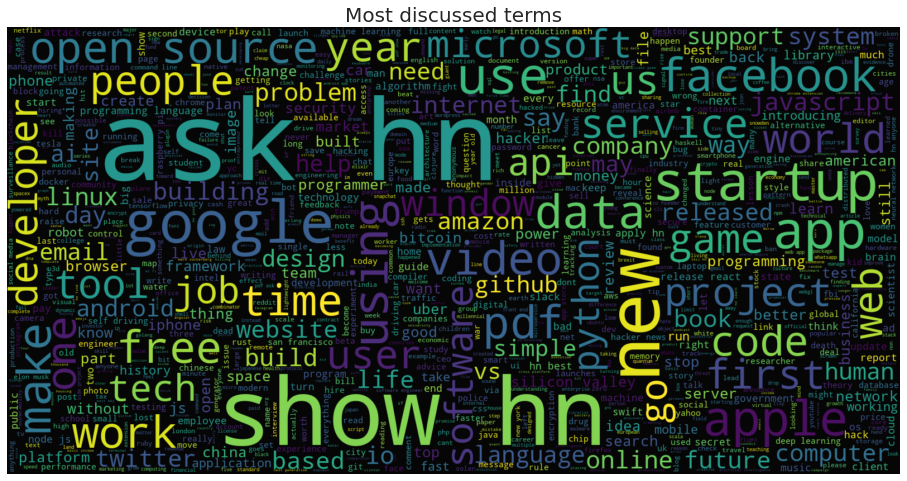

In [0]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", stopwords = STOPWORDS, max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

Text(0.5, 1.0, 'Comments and votes')

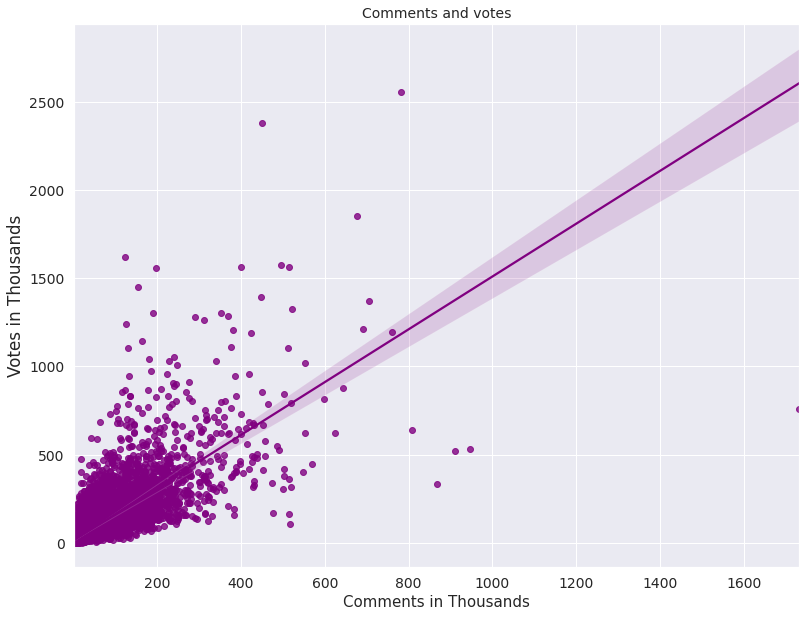

In [0]:
#positive correlation between points and comments
plt.figure(figsize = (13,10))

sns.regplot(data = hack, y = 'num_points', x = 'num_comments', color = 'purple')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.xlabel('Comments in Thousands', fontsize = 15)
plt.ylabel('Votes in Thousands')
plt.title('Comments and votes', fontsize = 14)

MODELLING BASELINE

In [0]:
import numpy as np 
import pandas as pd
import re
import gc
import fileinput
import string
import tensorflow as tf
import zipfile
import datetime
import sys
from tqdm  import tqdm
tqdm.pandas()
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import classification_report

Using TensorFlow backend.


Tokenization

In [0]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [0]:
stemmer = SnowballStemmer('english')

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [0]:
hack['title'].iloc[1]

'use open source shut fuck time'

In [0]:
doc_sample = hack['title'].iloc[1]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


original document: 
['use', 'open', 'source', 'shut', 'fuck', 'time']


 tokenized and lemmatized document: 
['open', 'sourc', 'shut', 'fuck', 'time']


In [0]:
processed_docs = hack['title'].map(preprocess)
processed_docs[:10]

0                             [interact, dynam, video]
1                      [open, sourc, shut, fuck, time]
2    [florida, face, feloni, april, fool, water, joke]
3                 [technolog, ventur, idea, enterpris]
4                         [note, note, make, steinway]
5            [titl, kill, invest, comcast, isp, spend]
6                             [nut, bolt, busi, advic]
7                             [improv, person, websit]
8    [shim, jig, woodwork, concept, conquer, techni...
9                                 [self, appendectomi]
Name: title, dtype: object

In [0]:
dictionary = gensim.corpora.Dictionary(processed_docs)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 dynam
1 interact
2 video
3 fuck
4 open
5 shut
6 sourc
7 time
8 april
9 face
10 feloni


In [0]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [0]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(62, 1), (631, 1), (920, 1), (1148, 1)]

In [0]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 62 ("thing") appears 1 time.
Word 631 ("know") appears 1 time.
Word 920 ("near") appears 1 time.
Word 1148 ("pretend") appears 1 time.


In [0]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6590538438627517), (1, 0.6083776613831182), (2, 0.44218169570860777)]


In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [0]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"googl" + 0.020*"secur" + 0.019*"program" + 0.013*"introduc" + 0.011*"citi" + 0.011*"android" + 0.010*"want" + 0.010*"servic" + 0.010*"encrypt" + 0.009*"industri"
Topic: 1 
Words: 0.037*"open" + 0.030*"sourc" + 0.025*"appl" + 0.024*"startup" + 0.021*"problem" + 0.017*"like" + 0.014*"twitter" + 0.014*"manag" + 0.013*"browser" + 0.013*"live"
Topic: 2 
Words: 0.032*"year" + 0.024*"releas" + 0.022*"compani" + 0.017*"test" + 0.016*"programm" + 0.011*"startup" + 0.010*"right" + 0.009*"face" + 0.008*"docker" + 0.008*"employe"
Topic: 3 
Words: 0.031*"build" + 0.022*"network" + 0.019*"hacker" + 0.018*"good" + 0.018*"thing" + 0.016*"develop" + 0.014*"drive" + 0.014*"internet" + 0.013*"futur" + 0.012*"free"
Topic: 4 
Words: 0.023*"engin" + 0.016*"googl" + 0.015*"search" + 0.013*"leav" + 0.012*"time" + 0.012*"america" + 0.009*"francisco" + 0.009*"work" + 0.008*"trump" + 0.008*"histori"
Topic: 5 
Words: 0.030*"languag" + 0.025*"work" + 0.019*"book" + 0.017*"time" + 0.016*"pro

In [0]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.015*"develop" + 0.014*"year" + 0.013*"program" + 0.012*"programm" + 0.012*"happen" + 0.012*"work" + 0.011*"make" + 0.009*"updat" + 0.009*"code" + 0.009*"music"
Topic: 1 Word: 0.011*"introduc" + 0.010*"problem" + 0.009*"solv" + 0.009*"stop" + 0.009*"futur" + 0.009*"launch" + 0.009*"design" + 0.008*"stori" + 0.008*"guid" + 0.008*"video"
Topic: 2 Word: 0.011*"learn" + 0.009*"like" + 0.009*"tech" + 0.009*"video" + 0.009*"microsoft" + 0.009*"search" + 0.008*"attack" + 0.008*"list" + 0.008*"write" + 0.007*"drive"
Topic: 3 Word: 0.017*"build" + 0.010*"come" + 0.009*"time" + 0.008*"love" + 0.008*"cost" + 0.007*"model" + 0.007*"power" + 0.007*"advic" + 0.007*"play" + 0.006*"review"
Topic: 4 Word: 0.014*"languag" + 0.013*"sourc" + 0.012*"python" + 0.012*"open" + 0.011*"linux" + 0.010*"project" + 0.008*"space" + 0.008*"get" + 0.008*"creat" + 0.008*"react"
Topic: 5 Word: 0.012*"hack" + 0.011*"engin" + 0.010*"book" + 0.010*"browser" + 0.009*"america" + 0.009*"amazon" + 0.009*"exper

In [0]:
processed_docs[4]

['note', 'note', 'make', 'steinway']

In [0]:
for index, score in sorted(lda_model[bow_corpus[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.4443887174129486	 
Topic: 0.033*"learn" + 0.022*"python" + 0.022*"video" + 0.017*"machin" + 0.017*"make" + 0.017*"world" + 0.015*"stori" + 0.014*"project" + 0.014*"go" + 0.013*"deep"

Score: 0.3556026518344879	 
Topic: 0.023*"googl" + 0.020*"secur" + 0.019*"program" + 0.013*"introduc" + 0.011*"citi" + 0.011*"android" + 0.010*"want" + 0.010*"servic" + 0.010*"encrypt" + 0.009*"industri"

Score: 0.02500416710972786	 
Topic: 0.032*"year" + 0.024*"releas" + 0.022*"compani" + 0.017*"test" + 0.016*"programm" + 0.011*"startup" + 0.010*"right" + 0.009*"face" + 0.008*"docker" + 0.008*"employe"

Score: 0.025002574548125267	 
Topic: 0.037*"open" + 0.030*"sourc" + 0.025*"appl" + 0.024*"startup" + 0.021*"problem" + 0.017*"like" + 0.014*"twitter" + 0.014*"manag" + 0.013*"browser" + 0.013*"live"

Score: 0.025000901892781258	 
Topic: 0.030*"languag" + 0.025*"work" + 0.019*"book" + 0.017*"time" + 0.016*"program" + 0.012*"imag" + 0.012*"build" + 0.011*"scienc" + 0.010*"engin" + 0.010*"swift"

S

In [0]:
unseen_document = 'How a Pentagon deal became an identity crisis for Google'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.4778180420398712	 Topic: 0.023*"engin" + 0.016*"googl" + 0.015*"search" + 0.013*"leav" + 0.012*"time"
Score: 0.32216063141822815	 Topic: 0.032*"year" + 0.024*"releas" + 0.022*"compani" + 0.017*"test" + 0.016*"programm"
Score: 0.025007322430610657	 Topic: 0.023*"googl" + 0.020*"secur" + 0.019*"program" + 0.013*"introduc" + 0.011*"citi"
Score: 0.02500283159315586	 Topic: 0.037*"open" + 0.030*"sourc" + 0.025*"appl" + 0.024*"startup" + 0.021*"problem"
Score: 0.025002747774124146	 Topic: 0.031*"build" + 0.022*"network" + 0.019*"hacker" + 0.018*"good" + 0.018*"thing"
Score: 0.025002144277095795	 Topic: 0.019*"valley" + 0.018*"silicon" + 0.017*"game" + 0.016*"facebook" + 0.014*"line"
Score: 0.025002077221870422	 Topic: 0.030*"languag" + 0.025*"work" + 0.019*"book" + 0.017*"time" + 0.016*"program"
Score: 0.025001907721161842	 Topic: 0.033*"learn" + 0.022*"python" + 0.022*"video" + 0.017*"machin" + 0.017*"make"
Score: 0.025001460686326027	 Topic: 0.024*"code" + 0.023*"user" + 0.020*"ja

In [0]:

from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
vectors = matrix.fit_transform(words).toarray()

In [0]:
vectors

array([[0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [0]:

from sklearn.model_selection import train_test_split
vectors_train, vectors_test = train_test_split(vectors)

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# # OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


ModuleNotFoundError: ignored

In [0]:
# #bert tokenization

# topic = []

# for i in words:
#   topic.append(str(i))

# text = topic
# marked_text = "[CLS] " + text + " [SEP]"


# # Tokenize our sentence with the BERT tokenizer.
# tokenized_text = tokenizer.tokenize(marked_text)

# # Print out the tokens.
# print (tokenized_text)

In [0]:
#text and label
#num points and title

hack.head()

,id,title,url,num_points,num_comments,author,created_at
0,12224879,Interactive Dynamic Video,http://www.interactivedynamicvideo.com/,386,52,ne0phyte,8/4/2016 11:52
1,10975351,How to Use Open Source and Shut the Fuck Up at...,http://hueniverse.com/2016/01/26/how-to-use-op...,39,10,josep2,1/26/2016 19:30
2,11964716,Florida DJs May Face Felony for April Fools' W...,http://www.thewire.com/entertainment/2013/04/f...,2,1,vezycash,6/23/2016 22:20
3,11919867,Technology ventures: From Idea to Enterprise,https://www.amazon.com/Technology-Ventures-Ent...,3,1,hswarna,6/17/2016 0:01
4,10301696,Note by Note: The Making of Steinway L1037 (2007),http://www.nytimes.com/2007/11/07/movies/07ste...,8,2,walterbell,9/30/2015 4:12


In [0]:
#pick two col
df=hack[['title','num_points']]

In [0]:
df.head()

,title,num_points
0,Interactive Dynamic Video,386
1,How to Use Open Source and Shut the Fuck Up at...,39
2,Florida DJs May Face Felony for April Fools' W...,2
3,Technology ventures: From Idea to Enterprise,3
4,Note by Note: The Making of Steinway L1037 (2007),8


In [0]:
#central tendancy in num points
df['num_points'].mean()

50.29606965174129

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a254bf8d0>]],
      dtype=object)

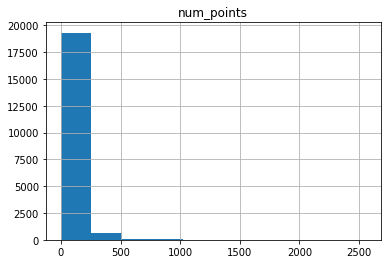

In [0]:
df.hist(column='num_points')

In [0]:
df['num_points'].unique()

array([ 386,   39,    2,    3,    8,   53,   34,   91,   18,   26,   59,
          7,    1,   28,  109,   68,   11,  170,   15,  115,  234,    4,
         61,  211,   51,   22,  747,    5,  171,  755,   38,   54,  296,
         29,   19,  244,   63,   60,   36,   73,  133,  226,    6,    9,
        162,   25,  110,  130,  222,   33,   85,  243,  131,   27,  142,
        149,   42,   64,   30,   13,   72,  114,   16,   21,   43,   47,
         71,  586,   49,   17,   12,   52,  255,   55,  180,  137,  107,
         32,   65,   74,   41,   78,   20,  233,   96,  128,  108,  160,
        207,   95,  292,   75,   10,  210,   48,   67,  151, 1005,   57,
        910,   66,   40,   46,  196,  188,   50,  304,  119,   97,   23,
        138,  381,   87,   69,   37,  294,  187,  153,  220,   35,   62,
         94,  127,  492,   14,  428,  100,  121,   99,  389,  146,   44,
        401,  102,  172,  248,  350,  216,  169,  437,  182,  103,  390,
        322,   56, 1851,   82,  218,   88,   77,  3

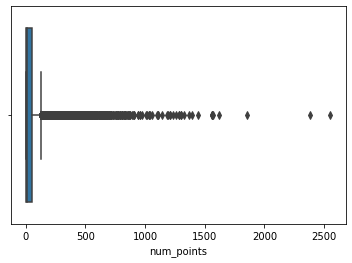

In [0]:
#outliers
import seaborn as sns
sns.boxplot(x=df['num_points'])

In [0]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

num_points    51.0
dtype: float64


In [0]:
print((df< (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))

       num_points  title
0            True  False
1           False  False
2           False  False
3           False  False
4           False  False
...           ...    ...
20095       False  False
20096       False  False
20097        True  False
20098        True  False
20099        True  False

[20100 rows x 2 columns]


In [0]:
df2 = df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]

In [0]:
df2

,title,num_points
1,use open source shut fuck time,39
2,florida djs may face felony april fools' water...,2
3,technology ventures: idea enterprise,3
4,note note: making steinway l1037 (2007),8
5,title ii kills investment? comcast isps spending,53
...,...,...
20092,thought leader gives talk inspire thoughts,4
20093,botnets streaming music services,120
20094,two new steps toward quantum computing,14
20095,purism avoids intels active management technology,10


In [0]:
df2['num_points'].isnull().any()

False

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a24f076a0>]],
      dtype=object)

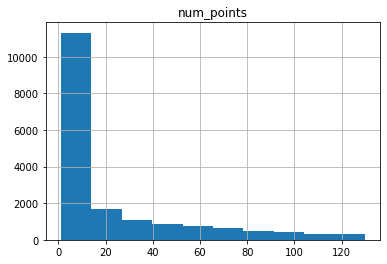

In [0]:
df2.hist(column='num_points')

In [0]:
df2['num_points'].unique()

array([ 39,   2,   3,   8,  53,  34,  91,  18,  26,  59,   7,   1,  28,
       109,  68,  11,  15, 115,   4,  61,  51,  22,   5,  38,  54,  29,
        19,  63,  60,  36,  73,   6,   9,  25, 110, 130,  33,  85,  27,
        42,  64,  30,  13,  72, 114,  16,  21,  43,  47,  71,  49,  17,
        12,  52,  55, 107,  32,  65,  74,  41,  78,  20,  96, 128, 108,
        95,  75,  10,  48,  67,  57,  66,  40,  46,  50, 119,  97,  23,
        87,  69,  37,  35,  62,  94, 127,  14, 100, 121,  99,  44, 102,
       103,  56,  82,  88,  77, 106, 123,  31,  98,  76,  24,  92, 105,
        79,  45, 120,  83,  90, 125,  93,  58, 129,  80, 124, 111,  70,
       126, 117,  89, 118,  81, 113,  84, 101, 112,  86, 104, 122, 116])

In [0]:
#function


# df_out['rating'] = np.where(df_out['num_points']<50, 'Not so popular', 
#                   np.where(df_out['num_points'] == 50, 'slightly popular',
#                   np.where(df_out['num_points'] >50, 'popular' )))



# def test(num_points):
#     if num_points == 50:
#         print("slightly popular")
#     elif num_points < 50:
#         print("not popular")
#     else:
#         # Handle values greater than zero.
#         if num_points > 150:
#             print("Out of range")
#         else:
#             print("popular")

In [0]:
ratings = []
for row in df2['num_points']:
  if row > 50:ratings.append('Popular')
  elif row < 50:ratings.append('Not popular')
  elif row == 50:ratings.append('slightly popular')
  else:
    ratings.append('not in range')
    # Create a column from the list
    df2['ratings'] = ratings
    

In [0]:
 df2['ratings'] =ratings
    # View the new dataframe
    # print(); print(df_out)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
 print(); print(df2)


                                                   title  ...      ratings
1                         use open source shut fuck time  ...  Not popular
2      florida djs may face felony april fools' water...  ...  Not popular
3                   technology ventures: idea enterprise  ...  Not popular
4                note note: making steinway l1037 (2007)  ...  Not popular
5       title ii kills investment? comcast isps spending  ...      Popular
...                                                  ...  ...          ...
20092         thought leader gives talk inspire thoughts  ...  Not popular
20093                   botnets streaming music services  ...      Popular
20094             two new steps toward quantum computing  ...  Not popular
20095  purism avoids intels active management technology  ...  Not popular
20096                   yc application translated broken  ...  Not popular

[17875 rows x 3 columns]


In [0]:
df3=df2[df2['ratings'] !='Slightly popular']
df3.head(20)

,title,num_points,ratings
1,How to Use Open Source and Shut the Fuck Up at...,39,Not popular
2,Florida DJs May Face Felony for April Fools' W...,2,Not popular
3,Technology ventures: From Idea to Enterprise,3,Not popular
4,Note by Note: The Making of Steinway L1037 (2007),8,Not popular
5,Title II kills investment? Comcast and other I...,53,Popular
6,Nuts and Bolts Business Advice,3,Not popular
7,Ask HN: How to improve my personal website?,2,Not popular
8,"Shims, Jigs and Other Woodworking Concepts to ...",34,Not popular
9,That self-appendectomy,91,Popular
10,Crate raises $4M seed round for its next-gen S...,3,Not popular


In [0]:

# import matplotlib.pyplot as plt
# # Pie chart
# labels = ['Popular','Not popular' ]
# sizes = df_out['ratings'].value_counts()
# #colors
# colors = ['#ADFF2F','#5F9EA0']
# #explsion
# explode = (0.05,0.05)
 
# plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
# #draw circle
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
# #Adjusts chart size
# sns.set(rc={'figure.figsize':(16, 8)})
# plt.title('Piechart of Positive and Negative Reviews') 
# plt.tight_layout()
# plt.show()

In [0]:

# Next, we am dropping the 'Neutral' sentiments as our goal was to only differentiate positive and negative tweets.
# After that, we filtered the review texts so only valid texts and words remain.
# Then, we defined the number of max features as 2000 and used the
# Tokenizer to vectorize and convert text into Sequences so the Network can deal with it as input."""

# #If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.
# max_features = 2000 

# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(df_out['title'].values)
# X = tokenizer.texts_to_sequences(df_out['title'].values)
# X = pad_sequences(X)

In [0]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Dense
# from tensorflow.keras import Sequential
from tensorflow import keras

In [0]:
pip install -U keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
df3.head()

,title,num_points,ratings
1,use open source shut fuck time,39,Not popular
2,florida djs may face felony april fools' water...,2,Not popular
3,technology ventures: idea enterprise,3,Not popular
4,note note: making steinway l1037 (2007),8,Not popular
5,title ii kills investment? comcast isps spending,53,Popular


## SVM

In [0]:
# one_hot = pd.get_dummies(df_out["ratings"])
# df_out.drop(['ratings'],axis=1,inplace=True)
# df_out = pd.concat([df_out,one_hot],axis=1)
# df_out.head()

# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df3['ratings']= label_encoder.fit_transform(df3['ratings']) 
  
df3['ratings'].unique() 

array([0, 1, 2])

## Take 1

In [0]:
df3.head()

,title,num_points,ratings
1,How to Use Open Source and Shut the Fuck Up at...,39,Not popular
2,Florida DJs May Face Felony for April Fools' W...,2,Not popular
3,Technology ventures: From Idea to Enterprise,3,Not popular
4,Note by Note: The Making of Steinway L1037 (2007),8,Not popular
5,Title II kills investment? Comcast and other I...,53,Popular


In [0]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df3['ratings']= label_encoder.fit_transform(df3['ratings']) 
  
df3['ratings'].unique() 

array([0, 1, 2])

In [0]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [0]:
df4 = df3.drop(["num_points"], axis=1)
df4.sample(3)

,title,ratings
1011,People are scared of Disruption,0
19812,Ask HN: What's your blog?,0
11731,Does Apple deliberately slow its old iPhones b...,0


In [0]:
df4['cleaned'] = df4['title'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in 'title']).lower())

In [0]:
df4.head()

,title,ratings,cleaned
1,How to Use Open Source and Shut the Fuck Up at...,0,how to use open sourc and shut the fuck up at ...
2,Florida DJs May Face Felony for April Fools' W...,0,florida djs may face feloni for april fool wat...
3,Technology ventures: From Idea to Enterprise,0,technolog ventur from idea to enterpris
4,Note by Note: The Making of Steinway L1037 (2007),0,note by note the make of steinway l
5,Title II kills investment? Comcast and other I...,1,titl ii kill invest comcast and other isp are ...


In [0]:
df5 = df4.drop(['title'], axis=1)
df5.sample(2)

,ratings,cleaned
339,1,declassifi cia document detail how to sabotag ...
5658,0,insideapp updat cordova app instant without re...


In [0]:
df5.describe()

,ratings
count,17875.000000
mean,0.178014
std,0.391784
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [0]:
# Splitting the dataset
X = df5['cleaned']
y = df5['ratings']

In [0]:
# Use 80% for training
# 
X_train, y_train = X[0:14300], y[0:14300]
X_test, y_test = X[14300:], y[14300:]

In [0]:
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.model_selection import GridSearchCV

In [0]:
# Extracting features
cv = CountVectorizer()
features = cv.fit_transform(X_train)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(features)

<14300x11925 sparse matrix of type '<class 'numpy.float64'>'
	with 110090 stored elements in Compressed Sparse Row format>

In [0]:
# Build a model
# 
from sklearn import svm
model = svm.SVC()
model.fit(features, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# Testing Accuracy
features_test = cv.transform(X_test)
scaler.fit_transform(features_test)


<3575x11925 sparse matrix of type '<class 'numpy.float64'>'
	with 25913 stored elements in Compressed Sparse Row format>

In [0]:
model.score(features_test, y_test)

0.8226573426573427

In [0]:
from sklearn.metrics import classification_report
classification_report(y_train, y_pred

In [0]:
key = cv.transform(['linux signal intern'])

In [0]:
print(model.predict(key))

[0]


**Hyperparameter Tuning**

In [0]:
tuned_params = {'kernel': ['linear', 'rbf'], 'gamma':[1e-3, 1e-4],
                'C': [1,10,100,1000]}
                

In [0]:
model1 = GridSearchCV(svm.SVC(), tuned_params)

In [0]:
model1.score(features_test, y_test)

In [0]:
model2 = svm.SVC(C=1.0, kernel='poly', gamma='scale', max_iter=3, probability=False, degree=3)
model2.fit(features, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=3, probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
model2.score(features_test, y_test)

0.8220979020979021

## Take 2

In [0]:
from sklearn.svm import LinearSVC_in_Progress
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [0]:
df5.head()

,num_points,cleaned
1,39,how to use open sourc and shut the fuck up at ...
2,2,florida djs may face feloni for april fool wat...
3,3,technolog ventur from idea to enterpris
4,8,note by note the make of steinway l
5,53,titl ii kill invest comcast and other isp are ...


In [0]:
#X_train, X_test, y_train, y_test = train_test_split(df5['cleaned'], df5.ratings, test_size=0.2)

In [0]:

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)),
                     ('chi',  SelectKBest(chi2, k=10000)),
                     ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))])


In [0]:
model = pipeline.fit(X_train, y_train)

In [0]:
print("accuracy score: " + str(model.score(X_test, y_test)))

accuracy score: 0.8


In [0]:
print(model.predict(['that was an awesome place. Great food!']))

[0]


In [0]:
print(model.predict(['linux signal intern']))

[1]


In [0]:
print(model.predict(['chat center facebook s uniqu chat id']))

[0]
